In [252]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import matplotlib.dates as dates

In [253]:
import uncertainties.unumpy as unp
import uncertainties as unc

In [254]:
import geopandas as gpd

### Functions

In [255]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [256]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [257]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [258]:
dfr = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [259]:
dfp['data'] = pd.to_datetime(dfp['data'])
dfr['data'] = pd.to_datetime(dfr['data'])
df['data'] = pd.to_datetime(df['data'])

In [260]:
fr = 'italia/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp'
mapr_df = gpd.read_file(fr)

fp = 'italia/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp'
mapp_df = gpd.read_file(fp)

In [ ]:
dfp = dfp.set_index('denominazione_provincia').join(mapp_df.set_index('DEN_PCM').geometry)
dfr = dfr.set_index('denominazione_regione').join(mapr_df.set_index('DEN_REG').geometry)

# ITALIA

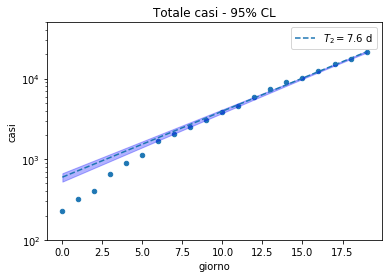

In [13]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim = [10**2,0.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('casi')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(max(df.data).date()), dpi = 300)

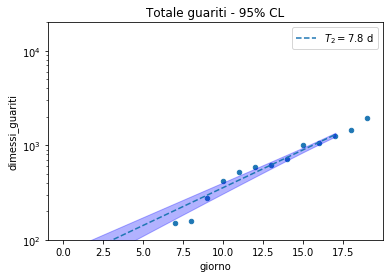

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 6

df.reset_index().plot.scatter(x='index',y='dimessi_guariti', ax = ax, logy = True, title = 'Totale guariti - 95% CL', ylim=[10**2,2*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.dimessi_guariti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_guariti_{}.png'.format(max(df.data).date()), dpi = 300)

# Province

## Singola Provincia

In [ ]:
provincia = 'LO'

fig, ax = plt.subplots()

x = np.arange(19)
px = np.arange(20)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(provincia), dpi = 300)

In [ ]:
dfp[dfp.sigla_provincia == provincia].to_csv('pr.csv')

## Analisi Province

In [16]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)
regioni = np.unique(dfp[dfp.denominazione_regione != ''].denominazione_regione.values)

In [17]:
time = max(dfp.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')]
df_forecast.loc[:,'data'] = time
sLength = len(df_forecast['data'])
df_forecast = df_forecast.assign(std = np.zeros(sLength))
#df_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr]
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].data.values - min(df_temp[df_temp.totale_casi > 0].data.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

In [41]:
df_forecast.to_csv('forecast_province_2020.03.15.csv')
df_forecast.totale_casi.sum()

25827.573439498792

In [80]:
merged = mapp_df.set_index('DEN_PCM').join(df_forecast.set_index('denominazione_provincia'))
merged['log_totale_casi'] = merged['totale_casi'].apply(lambda x: max(0,np.log10(x)))

In [95]:
merged.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,SIGLA,Shape_Leng,Shape_Area,...,stato,codice_regione,denominazione_regione,codice_provincia,sigla_provincia,lat,long,totale_casi,std,log_totale_casi
DEN_PCM,,,,,,,,,,,,,,,,,,,,,
Torino,1,1,1,201,201,-,Torino,TO,539249.812320,6.828137e+09,...,ITA,1.0,Piemonte,1.0,TO,45.073274,7.680687,428.653230,24.565543,2.632106
Vercelli,1,1,2,0,2,Vercelli,-,VC,418249.269903,2.082028e+09,...,ITA,1.0,Piemonte,2.0,VC,45.323981,8.423234,40.869389,2.965587,1.611398
Novara,1,1,3,0,3,Novara,-,NO,250242.386669,1.341320e+09,...,ITA,1.0,Piemonte,3.0,NO,45.445885,8.621916,68.654797,4.425073,1.836671
Cuneo,1,1,4,0,4,Cuneo,-,CN,490111.881760,6.898443e+09,...,ITA,1.0,Piemonte,4.0,CN,44.393296,7.551172,69.720395,4.960584,1.843360
Asti,1,1,5,0,5,Asti,-,AT,315561.373435,1.508948e+09,...,ITA,1.0,Piemonte,5.0,AT,44.899129,8.204143,86.584544,2.380345,1.937440


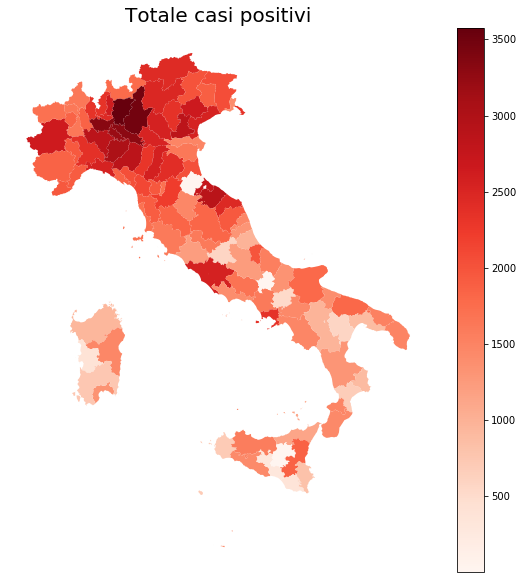

In [63]:
variable = 'log_totale_casi'
vmin, vmax  = min(merged[variable].values), max(merged[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

merged.plot(column = variable, cmap = 'Reds', ax = ax);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
scale = plt.cm.ScalarMappable(cmap ='Reds', norm = plt.Normalize(vmin=10**vmin, vmax=10**vmax))
cbar = fig.colorbar(scale)
plt.savefig('map.png', dpi = 300, bbox_inches = 'tight')

In [20]:
for reg in regioni:
    province = df_forecast[df_forecast.denominazione_regione == reg].denominazione_provincia.values
    if len(province)>4:
        col = 3
    elif len(province)>2:
        col = 2
    else: 
        col = 1
    row = int(len(province)/col) + (len(province)%col > 0) 
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12, 12), constrained_layout=True)
    day0, day1 = min(dfp.data.values) - np.timedelta64(1,'D'), max(dfp.data.values) + np.timedelta64(2,'D')

    if len(province)>1:
        for pr, ax in zip(province, axes.flat):
            x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
            y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
            yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
            ax.scatter(x,y, color = 'red', s = 30)
            ax.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

            dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = ax, title = pr, xlim =[day0,day1])
            locator = dates.AutoDateLocator(minticks=5, maxticks=7)
            formatter = dates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('')
            ax.set_ylabel('')
    else:
        x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
        y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
        yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
        axes.scatter(x,y, color = 'red', s = 30)
        axes.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

        dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = axes, title = pr, xlim =[day0,day1])
        locator = dates.AutoDateLocator(minticks=5, maxticks=7)
        formatter = dates.ConciseDateFormatter(locator)
        axes.xaxis.set_major_locator(locator)
        axes.xaxis.set_major_formatter(formatter)
        axes.set_xlabel('')
        axes.set_ylabel('')
        
    fig.suptitle('Regione ' + reg, size = 14)
    for i in range(len(province),row*col):
        fig.delaxes(axes.flat[i])
    fig.savefig('plot/Regione_'+reg+'_'+str(max(df.data).date())+'.png', dpi = 200)
    plt.close()

# Regioni

In [53]:
time = max(dfr.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

dfr_forecast = dfr[(dfr.data == max(dfr.data.values)) & (dfr.denominazione_regione != '')]
dfr_forecast.loc[:,'data'] = time
sLength = len(dfr_forecast)
dfr_forecast = dfr_forecast.assign(std = np.zeros(sLength))
dfr_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,std
399,2020-03-15 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,51,14,65,41,106,23,4,2,112,1232,0.0
400,2020-03-15 17:00:00,ITA,17,Basilicata,40.639471,15.805148,0,2,2,8,10,0,0,0,10,155,0.0
401,2020-03-15 17:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,26,7,33,137,170,47,0,3,173,1135,0.0
402,2020-03-15 17:00:00,ITA,18,Calabria,38.109228,15.643453,22,4,26,33,59,22,1,0,60,711,0.0
403,2020-03-15 17:00:00,ITA,15,Campania,40.839566,14.250850,72,17,89,154,243,30,23,6,272,1936,0.0


In [129]:
columns = dfr_forecast.columns[6:16]
for col in columns:
    d = {}
    for reg in regioni:
        df_temp = dfr[dfr.denominazione_regione == reg]
        #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
        df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        try:
            x = df_temp[df_temp[col] > 0].data.values - min(df_temp[df_temp[col] > 0].data.values)
            y = df_temp[df_temp[col] > 0].totale_casi.values
            popt, pcov = optimize.curve_fit(exponential, x, y)

            y0,tau = unc.correlated_values(popt, pcov)
            py = y0*unp.exp((max(x)+1)/tau)

            nom = py.nominal_value
            std_new = py.std_dev
        except:
            nom = 0
            std_new = 0
        d[reg] = [nom,std_new]
    dfr_forecast[col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][0])
    dfr_forecast['std_'+col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][1])

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:178: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:227: RuntimeWarning: invalid value encountered in less
  variances[variances < 0] = 0.


In [65]:
dfr_forecast.to_csv('forecast_regioni_{}.csv'.format(max(dfr_forecast.data).date()))
dfr_forecast.totale_casi.sum()

26315.919969885435

In [245]:
df

,stato,codice_regione,denominazione_regione,lat,long,popolazione
0,ITA,13.0,Abruzzo,42.351222,13.398438,1311580
1,ITA,17.0,Basilicata,40.639471,15.805148,562869
2,ITA,4.0,P.A. Bolzano,46.499335,11.356624,531178
3,ITA,18.0,Calabria,38.905976,16.594402,1947131
4,ITA,15.0,Campania,40.839566,14.250850,5801692
5,ITA,8.0,Emilia-Romagna,44.494367,11.341721,4459477
6,ITA,6.0,Friuli Venezia Giulia,45.649435,13.768136,1215220
7,ITA,12.0,Lazio,41.892770,12.483667,5879082
8,ITA,7.0,Liguria,44.411493,8.932699,1550640
9,ITA,3.0,Lombardia,45.466794,9.190347,10060574


In [246]:
df = pd.read_csv('../model-DummyExp/dati_regioni.csv')
df.loc[df.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

dfr_forecast.loc[dfr_forecast.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

In [247]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr_forecast.set_index('denominazione_regione'))
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr = mergedr.rename(index = {'Trento': 'P.A. Trento', 'Bolzano': 'P.A. Bolzano'})
mergedr = mergedr.join(df.set_index('denominazione_regione')['popolazione'])

#mergedr.loc['P. A. Trento',:] = mergedr['Trento']
#mergedr.loc['P. A. Bolzano',:] = mergedr['Bolzano']

In [248]:
mergedr

,COD_RIP,COD_REG,Shape_Leng,Shape_Area,geometry,data,stato,codice_regione,lat,long,...,COD_CM,COD_PCM,DEN_PROV,DEN_CM,SIGLA,denominazione_regione,codice_provincia,sigla_provincia,log_totale_casi,popolazione
Piemonte,1,1,1.235676e+06,2.539388e+10,"POLYGON ((457749.463 5145501.795, 458662.394 5...",2020-03-15 17:00:00,ITA,1.0,45.073274,7.680687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4356406.0
Valle d'Aosta,1,2,3.111393e+05,3.258907e+09,"POLYGON ((390652.643 5091766.170, 390748.643 5...",2020-03-15 17:00:00,ITA,2.0,45.737503,7.320149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125666.0
Lombardia,1,3,1.410209e+06,2.386241e+10,"MULTIPOLYGON (((595652.358 5163515.658, 596042...",2020-03-15 17:00:00,ITA,3.0,45.466794,9.190347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10060574.0
Trentino-Alto Adige,2,4,8.008937e+05,1.360755e+10,"POLYGON ((743267.749 5219765.793, 743387.812 5...",NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Veneto,2,5,1.056150e+06,1.834326e+10,"POLYGON ((768123.959 5175397.496, 768135.209 5...",2020-03-15 17:00:00,ITA,5.0,45.434905,12.338452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4905854.0
Friuli Venezia Giulia,2,6,6.671234e+05,7.926128e+09,"MULTIPOLYGON (((852603.483 5080093.184, 852981...",2020-03-15 17:00:00,ITA,6.0,45.649435,13.768136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1215220.0
Liguria,1,7,8.254679e+05,5.415023e+09,"MULTIPOLYGON (((459010.230 4906246.580, 458965...",2020-03-15 17:00:00,ITA,7.0,44.411493,8.932699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1550640.0
Emilia-Romagna,2,8,1.163390e+06,2.245033e+10,"MULTIPOLYGON (((572180.306 4994427.401, 572265...",2020-03-15 17:00:00,ITA,8.0,44.494367,11.341721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4459477.0
Toscana,3,9,1.306398e+06,2.298245e+10,"MULTIPOLYGON (((625766.324 4754785.020, 625776...",2020-03-15 17:00:00,ITA,9.0,43.769231,11.255889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3729641.0
Umbria,3,10,6.197653e+05,8.464343e+09,"MULTIPOLYGON (((771322.147 4833085.133, 771317...",2020-03-15 17:00:00,ITA,10.0,43.106758,12.388247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,882015.0


## Totale casi previsti

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


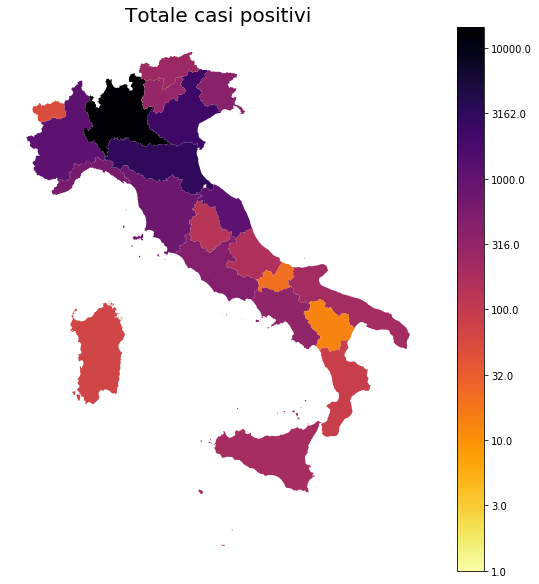

In [262]:
mergedr['log_totale_casi'] = mergedr['totale_casi'].apply(lambda x: max(0,np.log10(x)))
variable = 'log_totale_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])
print(yticks)

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels([round(10**ytick) for ytick in yticks])
plt.savefig('map_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')

In [249]:
mergedr['log_perc_casi'] = mergedr[['totale_casi', 'popolazione']].apply(lambda x: np.log10(x[0]/x[1]), axis = 1)

In [250]:
mergedr['log_perc_casi'] 

Piemonte                -3.574287
Valle d'Aosta           -3.392127
Lombardia               -2.842926
Trentino-Alto Adige           NaN
Veneto                  -3.336053
Friuli Venezia Giulia   -3.474882
Liguria                 -3.397936
Emilia-Romagna          -3.145933
Toscana                 -3.670493
Umbria                  -3.821575
Marche                  -3.127151
Lazio                   -4.112056
Abruzzo                 -3.924189
Molise                  -4.156797
Campania                -4.242042
Puglia                  -4.265866
Basilicata              -4.621567
Calabria                -4.366012
Sicilia                 -4.393720
Sardegna                -4.385778
P.A. Trento             -3.250743
P.A. Bolzano            -3.306784
Name: log_perc_casi, dtype: float64

[-4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3. ]


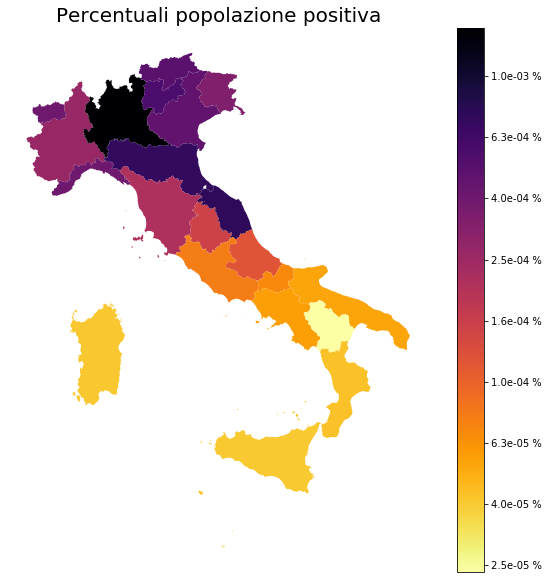

In [251]:
variable = 'log_perc_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Percentuale popolazione positiva', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])
print(yticks)

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels(['{:3.1e} %'.format(10**ytick) for ytick in yticks])
#['{:5.2e}'.format(x) for x in leak] 
plt.savefig('map_perc_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')